# Demo MLP 


We will revisit classifying flower from the iris dataset in this notebook and compare an MLP with one hidden layer against the softmax classifier. Recall that the Iris dataset contains 150 examples of Iris flowers belonging to 3 species *Iris-setosa*, *Iris-versicolor* and, *Iris-virginica*. Each example has 4 features *sepal length*, *sepal width*, *petal length*, and *petal width*. See the image below for an illustration.

We will use 90 samples (30 per class) for trainnig our model and evaluate the model on the remaining 60 samples (20 per class). 


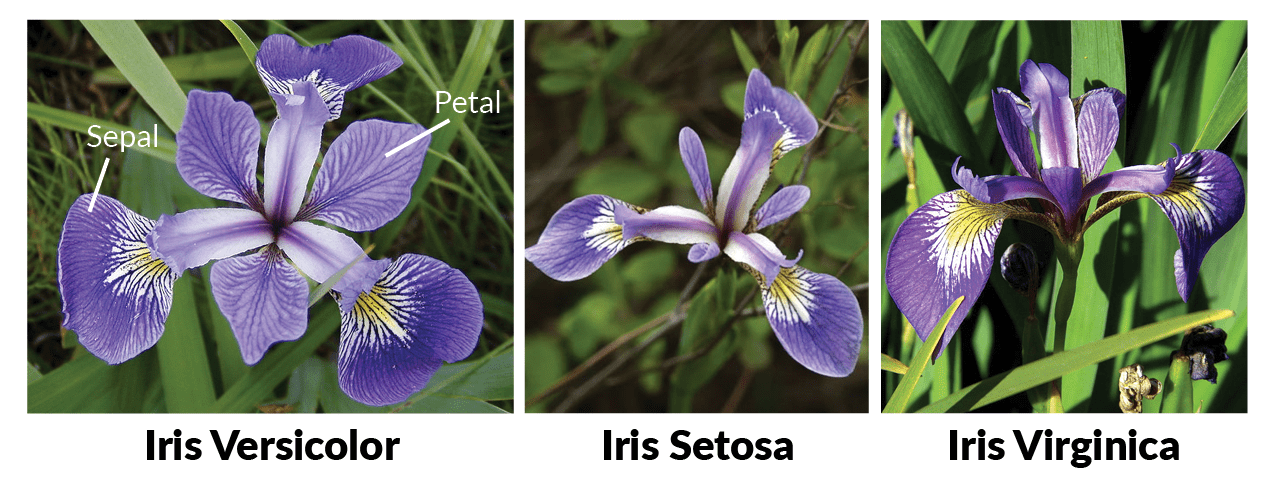





Below, we will read the data from an NPZ file. The file contains four arrays, namely 
- **trnX:** A $90 \times 4$ matrix storing training observations (each row is one training sample)
- **trn_labels:** An array of size 90 storing the associated labels for each row of **trnX**
- **tstX:** A $60 \times 4$ matrix storing test samples (each row is one sample)
- **tst_labels:** An array of size 60 storing the associated labels for each row of **tstX** 

   

In [ ]:
import numpy as np

np.random.seed(10) # to have the same results every time we call the Numpy's random functions

npzfile = np.load('iris_mlp.npz')
trnX = npzfile['trnX']
tstX = npzfile['tstX']
trn_labels = npzfile['trn_labels']
tst_labels = npzfile['tst_labels']



For a softmax classifier, we need to convert our labels to one-hot coded vectors. The code below does this for us. 

In [ ]:
def create_one_hot(labels):
    """Convert class labels from scalars to one-hot vectors."""
    num_samples = labels.size
    num_classes = np.unique(labels).size
    labels_one_hot = np.zeros((num_samples, num_classes))
    labels_one_hot[np.arange(num_samples),labels-labels.min()] = 1
    return labels_one_hot



num_samples, num_features = trnX.shape
num_classes = np.unique(trn_labels).size
"""Convert class labels from scalars to one-hot vectors."""
trnY = create_one_hot(trn_labels)
tstY = create_one_hot(tst_labels)


Recall that the softmax classifier has the form
\begin{align} 
p = \mathrm{softmax}\big({z}\big) &= 
\mathrm{softmax}\big({W}^\top {x} \big)\\
\mathrm{softmax}\big({z_1,z_2,\cdots,z_K}\big) &= \frac{1}{\sum_i \exp(z_i)} 
\big(\exp(z_1),\exp(z_2),\cdots,\exp(z_K)\big)^\top
\end{align}

The code below realizes the softmax classifier.

In [ ]:
def softmax(x):
    z1 = np.exp(x)
    z = z1.T/np.sum(z1,axis=1)
    return(z.T)


The CE loss (NLL of softmax output) is:

\begin{align}
    \mathcal{L}_{\mathrm{NLL}}\big({W}\big) \triangleq -
    \sum_{i=1}^m {y}_i^\top \log\big(\hat{y}_i\big)\;.   
\end{align}
with $\hat{y}_i = \mathrm{softmax}\big({W}^\top {x}_i \big)$.
The function below implements the NLL loss. Note that we do not scale the loss by a factor of $1/m$ in this example. 

In [ ]:
import numpy as np
np.finfo(float).eps

In [ ]:
def nll_loss(y,y_hat):
    idx = np.argwhere(y.ravel()==1)
    tmp_val = y_hat.ravel()[idx]
    tmp_val[tmp_val < np.finfo(float).eps] = np.finfo(float).eps 
    loss = -np.log(tmp_val).sum()
    return loss


Let us evaluate our softmax classifier first.

In [ ]:
# Softmax
W = np.random.randn(num_features,num_classes)
#max_iter = 500
lr = 0.001
max_iter = 500
loss_softmax = []
for iter in range(max_iter):
    h = np.matmul(trnX,W)
    y_hat = softmax(h)
    tmp_loss = nll_loss(trnY,y_hat)
    loss_softmax.append(tmp_loss)
    grad = np.matmul(trnX.T,(y_hat-trnY))
    W -= lr*grad
    
    # computing accuracy
    if np.mod(iter, 10) == 1:
        h = np.matmul(tstX,W)
        y_hat = softmax(h) 
        pred_label = np.argmax(y_hat, axis=1)
        acc_iter = np.mean(pred_label==tst_labels)
        print(f'Softmax - iter:{iter:3} :  loss={tmp_loss:.3f}, test accuracy= {100*acc_iter:.2f}')

## MLP

Seems we have learned something useful. Now try to perform the following

* can you add a bias to the model?

* the learning rate is an impoprtant parameter of the model. increase it and study teh behavior of the algorithm

* as discussed in the class, the direct implementation of the softmax function is prone to neumerical instabilities. Implement a robust softmax function using the invariance property of the softmax.

* related to the above, implement a robust loss using the log-sum trick

As for the activation function, we will use a ReLU function defined as

$\mathrm{ReLU}(x) = \max(x,0)$ (see below)
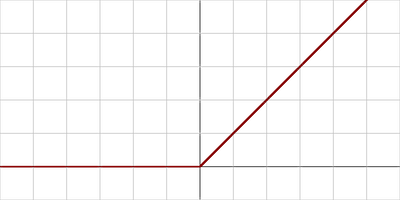

The code below implements the ReLU function.


In [ ]:
def relu(x):
    return(np.maximum(x, 0))

Our MLP model has the following structure



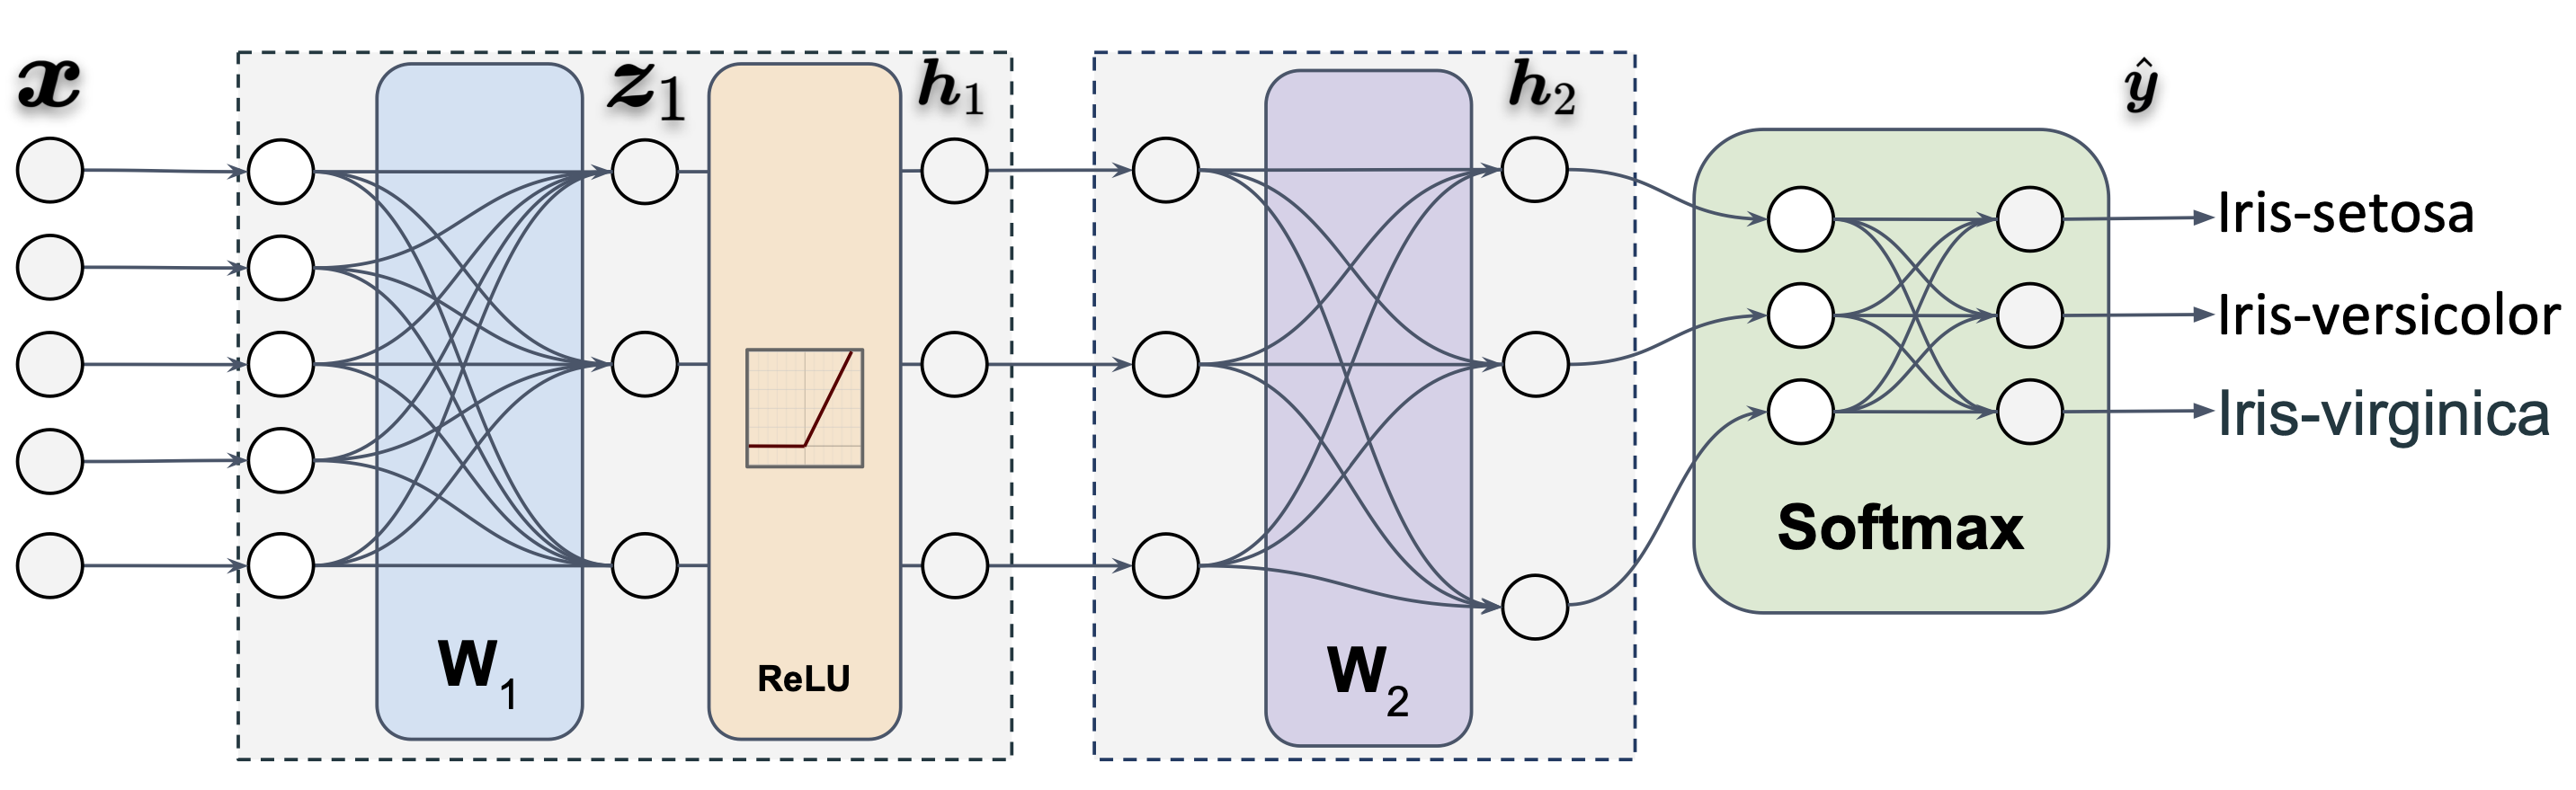


The following equations provide us with the gradient information to perform GD

\begin{align}
\nabla_{W_2}\mathcal{L} &= h_1\Big(\nabla_{h_2}\mathcal{L}\Big)^\top\\
\nabla_{W_1}\mathcal{L} &= x\Big(\nabla_{z_1}\mathcal{L}\Big)^\top\\
\end{align}
with
\begin{align}
\nabla_{h_2}\mathcal{L} &= \hat{y} - y\\
\nabla_{h_1}\mathcal{L} &= W_2\nabla_{h_2}\mathcal{L}\\
\nabla_{z_1}\mathcal{L} &= \nabla_{h_1}\mathcal{L}\odot\mathrm{sign}(h_1)\\
\end{align}

In [ ]:
# MLP
n0 = num_features #number of input features
n1 = 100 #size of the hidden layer
n2 = num_classes #number of classes
W1 = np.random.rand(n0,n1)
W2 = np.random.rand(n1,n2)




lr = 0.0005
max_iter = 500
loss_mlp = []
for iter in range(max_iter):
    #forward pass
    z1 = np.matmul(trnX,W1)
    h1 = relu(z1)
    h2 = np.matmul(h1,W2)
    y_hat = softmax(h2)  
    
    tmp_loss = nll_loss(trnY,y_hat)
    loss_mlp.append(tmp_loss)
    
    #backward pass
    dldh2 = (y_hat - trnY) 
    dldW2 = np.matmul(h1.T,dldh2)
    
    
    dldh1 = np.matmul(dldh2,W2.T)
    dldz1 = dldh1*np.sign(z1)
    dldW1 = np.matmul(trnX.T,dldz1)
    
    # GD
    W2 -= lr*dldW2
    W1 -= lr*dldW1
    
    if np.mod(iter, 10) == 1:
        h1 = np.matmul(tstX,W1)
        h2 = relu(h1)
        h3 = np.matmul(h2,W2)
        y_hat = softmax(h3) 
        pred_label = np.argmax(y_hat, axis=1)
        acc_iter = np.mean(pred_label==tst_labels)
        print(f'MLP - iter:{iter:3}  loss={tmp_loss:.3f}, test accuracy={100*acc_iter:.2f}')

## Questions.